#### Transfer Learning for Image Classification

In [1]:
#imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import pathlib
import numpy as np

In [2]:
#configurations
batch_size = 32
# 5 types of flowers
num_classes = 5
# training for 10 epochs
epochs = 10
# size of each image
IMAGE_SHAPE = (224, 224, 3)

In [3]:
def load_data():
    """This function downloads, extracts, loads, normalizes and one-hot encodes Flower Photos dataset"""
    # download the dataset and extract it
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
    data_dir = pathlib.Path(data_dir)
    # count how many images are there
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Number of images:", image_count)
    # get all classes for this dataset (types of flowers) excluding LICENSE file
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    # roses = list(data_dir.glob('roses/*'))
    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, CLASS_NAMES

In [4]:

def create_model(input_shape):
    # load MobileNetV2
    model = MobileNetV2(input_shape=input_shape)
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    model.summary()
    # training the model using adam optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [5]:
if __name__ == "__main__":
    # load the data generators
    train_generator, validation_generator, class_names = load_data()
    # constructs the model
    model = create_model(input_shape=IMAGE_SHAPE)
    # model name
    model_name = "MobileNetV2_finetune_last5"
    # some nice callbacks
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    checkpoint = ModelCheckpoint(os.path.join("results", f"{model_name}" + "-loss-{val_loss:.2f}.h5"),
                                save_best_only=True,
                                verbose=1)
    # make sure results folder exist
    if not os.path.isdir("results"):
        os.mkdir("results")
    # count number of steps per epoch
    training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
    validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
    # train using the generators
    model.fit_generator(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1, callbacks=[tensorboard, checkpoint])

228813984/228813984 [==============================] - 3s 0us/step
Number of images: 3670
Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
14536120/14536120 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 1.5280 - accuracy: 0.6267
Epoch 1: val_loss improved from inf to 1.45833, saving model to results/MobileNetV2_finetune_last5-loss-1.46.h5
92/92 [==============================] - 151s 2s/step - loss: 1.5280 - accuracy: 0.6267 - val_loss: 1.4583 - val_accuracy: 0.7524
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 1.3497 - accuracy: 0.8442
Epoch 2: val_loss improved from 1.45833 to 1.29586, saving model to results/MobileNetV2_finetune_last5-loss-1.30.h5
92/92 [==============================] - 144s 2s/step - loss: 1.3497 - accuracy: 0.8442 - val_loss: 1.2959 - val_accuracy: 0.7934
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 1.1935 - accuracy: 0.8778
Epoch 3: val_loss improved from 1.29586 to 1.16582, saving model to results/MobileNetV2_finetune_last5-loss-1.17.h5
92/92 [==============================] - 144s 2s/step - loss: 1.1935 - accuracy: 0.8778 - val_loss: 1.1658 - val_a

In [7]:
# load the data generators
train_generator, validation_generator, class_names = load_data()
# constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
# load the optimal weights
model.load_weights("results/MobileNetV2_finetune_last5-loss-0.70.h5")
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
# print the validation loss & accuracy
evaluation = model.evaluate_generator(validation_generator, steps=validation_steps_per_epoch, verbose=1)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1])

Number of images: 3670
Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  if __name__ == '__main__':


23/23 [==============================] - 28s 1s/step - loss: 0.6984 - accuracy: 0.8769
Val loss: 0.6984477043151855
Val Accuracy: 0.8768810033798218


1/1 [==============================] - 1s 1s/step


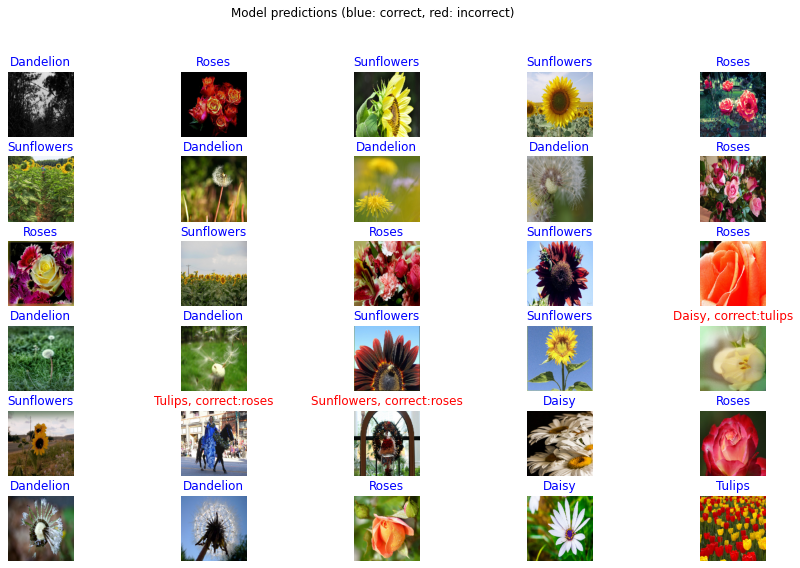

In [9]:
# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(15,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()